In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import itertools
from numba import jit
from tqdm import tqdm

In [2]:
%load_ext line_profiler

I can add visual delay later to account for bigger RT at the beginning

In [3]:
@jit(nopython=True)
def get_planning_coefs(strategy, capacity, param):
    if strategy == 0:
        return exp_normalized_planning_jit(capacity, param)
    elif strategy == 1:
        return inv_normalized_planning_jit(capacity)
    else:
        raise ValueError("Unknown strategy")

@jit(nopython=True)
def exp_normalized_planning_jit(capacity, param):
    x = np.arange(capacity)
    theta = np.exp(-x * np.log(param))
    theta /= np.sum(theta)
    return theta

@jit(nopython=True)
def inv_normalized_planning_jit(capacity):
    x = np.arange(capacity)
    theta = 1 / (x + 1)
    theta /= np.sum(theta)
    return theta

In [4]:
def calc_visual_drifts(seq, seq_length):
    seq_fingers = np.array([int(_) for _ in seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = 1


    return result



In [5]:
seq = '135242325141352423251413524232514'
seq_length = len(seq)

window_sizes = [1,2,3,4,11, 15, 30]

visual_drift_coef = 1
drifts = calc_visual_drifts(seq, seq_length)

# drifts = np.array([1,1,1,1,2]).reshape(5, 1)
# drifts = np.repeat(drifts, seq_length , axis = 1)

visual_delay = 100

diffusion = 5
threshold = 300


In [6]:
def exp_normalized_planning(capacity=3, param = 3):
    """
    Exponential decay function for planning

    args: 
        capacity (int): capacity of planning
        param (list/np.array): rate
    """
    x = np.arange(capacity)
    theta = np.exp(-x * np.log(param))
    theta /= sum(theta)

    return theta


def inv_normalized_planning(capacity=3):
    x = np.arange(capacity)
    theta = 1/(x+1)
    theta /= sum(theta)

    return theta

In [7]:
def calculate_IPI_from_press_time(press_times):
   return [press_times[0]] + [press_times[i] - press_times[i-1] for i in range(1, len(press_times))]

In [8]:
@jit(nopython=True)
def simulate_ddm(drifts, diffusion, threshold, dt, max_time, seq_length, window_size, planning_capacity, planning_param, planning_strategy, visual_delay):
    evidence = np.zeros((5, seq_length))
    time = 0
    visual_delay_queue = np.zeros(min(window_size, seq_length, planning_capacity))
    current_press = 0
    effective_planning_capacity = 0
    visible_window_size = 0

    planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)


    sqrt_dt = np.sqrt(dt)
    drifts_dt = drifts * dt
    diffusion_term = diffusion * sqrt_dt

    total_steps = int(max_time / dt)
    random_terms = np.random.randn(5, total_steps)

    t_index = 0

    press_times = np.full(seq_length, np.nan)

    while time < max_time:
        time += dt
        visual_delay_queue += dt
        t_index += 1

        for press in range(current_press, min(current_press + visible_window_size, seq_length, current_press + planning_capacity)):
            evidence[:, press] += planning_coefs[press - current_press] * drifts_dt[:, press] + diffusion_term * random_terms[:, t_index]


        if (evidence[:, current_press:min(current_press + visible_window_size, seq_length, current_press + planning_capacity)] >= threshold).any():
            visible_window_size -= 1
            press_times[current_press] = time
            current_press += 1
            visual_delay_queue = np.append(visual_delay_queue, 0)
            effective_planning_capacity = min(visible_window_size, seq_length - current_press, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)

            if current_press == seq_length:
                break

        visual_delay_passed_mask = (visual_delay_queue >= visual_delay)
        pass_count = sum(visual_delay_passed_mask)
        if pass_count > 0:
            visible_window_size += pass_count
            visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
            effective_planning_capacity = min(visible_window_size, seq_length - current_press, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)


    return press_times

In [9]:
class DriftDiffusionModel_Optimzied:
    def __init__(self, drifts, diffusion, threshold, dt = 1, max_time = 100000,  #todo: when changing dt, the round(time, 2) should be changed according to the precision of dt
                 seq_length = 11, window_size = 2, planning_capacity = 3, planning_param = 3,  
                 planning_strategy = 0, visual_delay = visual_delay): #todo: consider having different diffusions for different fingers (e.g. should we have different one when interference happens?)
        """
        Initialize the Drift-Diffusion Model.

        Parameters:
        drifts (list of float): List of drift rates for each process.
        diffusion (float): Diffusion coefficient (assumed to be the same for all processes).
        threshold (float): Decision threshold.
        dt (float): Time step for the discrete-time simulation.
        max_time (float): Maximum simulation time to prevent infinite loops.
        """
        self.seq_length = seq_length
        self.presses = [None for _ in range(seq_length)]
        self.window_size = window_size
        assert drifts.shape == (5,seq_length), "There must be exactly 5 drift rates."
        self.drifts = drifts 
        self.diffusion = diffusion
        self.threshold = threshold
        self.dt = dt
        self.max_time = max_time
        self.planning_strategy = planning_strategy
        self.planning_capacity = planning_capacity
        self.planning_param = planning_param
        self.press_times = [None for _ in range(seq_length)]
        self.visual_delay = visual_delay
    

    def simulate(self):
        press_times = simulate_ddm(self.drifts, self.diffusion, self.threshold, self.dt, self.max_time, self.seq_length, self.window_size, self.planning_capacity, self.planning_param, self.planning_strategy, self.visual_delay)
        self.press_times = press_times
        return calculate_IPI_from_press_time(self.press_times)
    


    def plot_IPIs(self):
        plt.plot(range(self.seq_length), calculate_IPI_from_press_time(self.press_times))
        plt.show()
                
    
    
    def plot_simulations(self):
        """
        Plot the evidence accumulation for the specified number of simulations.

        Parameters:
        num_simulations (int): Number of simulations to plot.
        """ 
        
        fig, axs = plt.subplots(self.seq_length, figsize=(15,20))
        evidence = np.zeros((5, self.seq_length))
        evidence_over_time = np.zeros((5, self.seq_length, int(self.max_time/self.dt)))
        time = 0
        t_index = 0
        visual_delay_queue = np.array([0] * min(self.window_size, self.seq_length, self.planning_capacity))
        current_press = 0
        planning_capacity = 0
        planning_coefs = self.planning_strategy(capacity = planning_capacity, param = self.planning_param)
        visible_window_size = 0
        # visual_delay_passed = False

        while time < self.max_time:
            time += self.dt
            t_index += 1
            visual_delay_queue += self.dt
            # current_press_time += self.dt

            for press in range(current_press, min(current_press + visible_window_size, self.seq_length,current_press + self.planning_capacity)):
                for finger in range(5):
                    evidence[finger, press] += planning_coefs[press - current_press] * self.drifts[finger, press] * self.dt + self.diffusion * np.sqrt(self.dt) * np.random.randn()
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]

            for press in range(0, current_press):
                for finger in range(5):
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]

            if (evidence[: , current_press:min(current_press + visible_window_size, self.seq_length, current_press + self.planning_capacity)] >= self.threshold).any():
                # visual_delay_passed = False
                visible_window_size -= 1
                current_press += 1
                visual_delay_queue = np.append(visual_delay_queue, 0)
                planning_capacity = min(visible_window_size, self.seq_length - current_press, self.planning_capacity)
                planning_coefs = self.planning_strategy(capacity = planning_capacity, param = self.planning_param)

                if current_press == self.seq_length:
                    break

            visual_delay_passed_mask = (visual_delay_queue >= self.visual_delay)
            pass_count = sum(visual_delay_passed_mask)
            if pass_count > 0:
                visible_window_size += pass_count
                visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
                planning_capacity = min(visible_window_size, self.seq_length - current_press, self.planning_capacity)
                planning_coefs = self.planning_strategy(capacity = planning_capacity, param = self.planning_param) 
            
            # if current_press_time >= self.visual_delay:
            #     if ~visual_delay_passed:
            #         visual_delay_passed = True
            #         visible_window_size = self.window_size
            #         planning_capacity = min(visible_window_size, self.seq_length - current_press, self.planning_capacity)
            #         planning_coefs = self.planning_strategy(capacity = planning_capacity)
                    

        for press in range(self.seq_length):
            for finger in range(5):
                axs[press].plot(np.arange(0, np.round(time, 2), self.dt), evidence_over_time[finger, press, :t_index], label = f'Finger {finger+1}')
            axs[press].axhline(y = self.threshold, color = 'r', linestyle = '--', label = 'Threshold')
            axs[press].set_xlabel('Time')
            # axs[press].set_ylabel('Evidence')
            axs[press].set_title(f'Press {press + 1}')

        fig.supylabel('Evidence')

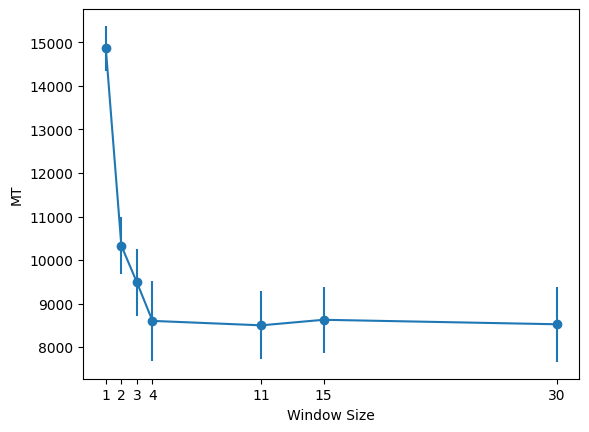

In [10]:
MT = {window: [] for window in window_sizes}
num_sims = 40
for window in MT.keys():
    model = DriftDiffusionModel_Optimzied(drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, seq_length=seq_length)
    for _ in range(num_sims):
        IPIs = model.simulate()
        MT[window].append(sum(IPIs))


#Calculating mean and std for each window size
MT_mean = {window: np.mean(MT_vals) for window, MT_vals in MT.items()}
MT_std = {window: np.std(MT_vals) for window, MT_vals in MT.items()}

plt.errorbar(MT_mean.keys(), MT_mean.values(), yerr=list(MT_std.values()), fmt='-o')
plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('MT')
plt.show()


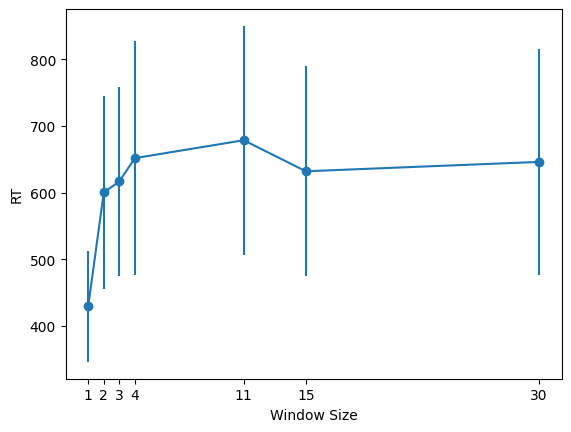

In [24]:
RT = {window: [] for window in window_sizes}
num_sims = 40
for window in RT.keys():
    model = DriftDiffusionModel_Optimzied(drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, seq_length=seq_length)
    for _ in range(num_sims):
        IPIs = model.simulate()
        RT[window].append(IPIs[0])


#Calculating mean and std for each window size
RT_mean = {window: np.mean(RT_vals) for window, RT_vals in RT.items()}
RT_std = {window: np.std(RT_vals) for window, RT_vals in RT.items()}

plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
plt.xticks(window_sizes)
plt.xlabel('Window Size')
plt.ylabel('RT')
plt.show()


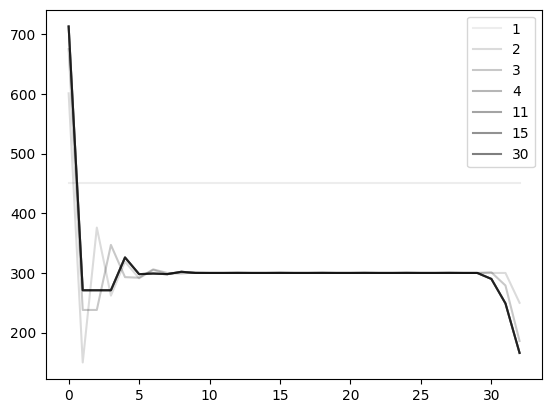

In [32]:

num_sims = 1
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(drifts = drifts, diffusion = 0, threshold = threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, seq_length=seq_length)
    for sim in range(num_sims):
        IPIs = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))



plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


In [33]:
for window in window_sizes:
    print('window = ', window, "   ", np.mean(IPI_mean[window][15:25]))


window =  1     450.0
window =  2     300.0
window =  3     300.4
window =  4     300.0
window =  11     300.0
window =  15     300.0
window =  30     300.0


100%|██████████| 7/7 [12:39<00:00, 108.51s/it]


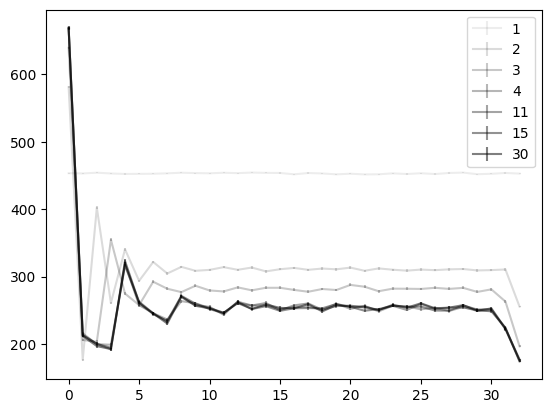

In [30]:

num_sims = 10000
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in tqdm(IPI.keys()):
    model = DriftDiffusionModel_Optimzied(drifts = drifts, diffusion=diffusion, threshold = threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, seq_length=seq_length)
    for sim in range(num_sims):
        IPIs = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    # plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))



plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


In [31]:
for window in window_sizes:
    print('window = ', window, "   ", np.mean(IPI_mean[window][15:25]))


window =  1     452.39842
window =  2     310.85888000000006
window =  3     281.67287999999996
window =  4     254.14164
window =  11     254.21860999999998
window =  15     253.49081999999999
window =  30     254.38013


100%|██████████| 50000/50000 [09:37<00:00, 86.54it/s]


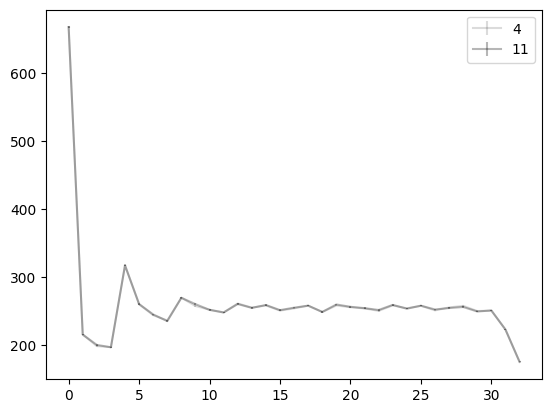

In [14]:
num_sims = 50000
IPI = {window: np.empty((seq_length, num_sims)) for window in [4, 11]}

for window in IPI.keys():
    model = DriftDiffusionModel_Optimzied(drifts, diffusion, threshold, window_size=window, visual_delay=150, planning_capacity=4, planning_param=2, seq_length=seq_length)
    for sim in tqdm(range(num_sims), miniters=1000):
        IPIs = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(len(window_sizes)))
    # plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))



plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


100%|██████████| 7/7 [01:19<00:00, 11.35s/it]


*********Delay =  0  ********************
window =  1     302.9347
window =  2     288.3497
window =  3     267.2376
window =  4     234.96160000000003
window =  11     235.92439999999996
window =  15     240.58059999999995
window =  30     237.22000000000003


100%|██████████| 7/7 [01:20<00:00, 11.48s/it]


*********Delay =  90  ********************
window =  1     393.591
window =  2     303.0233
window =  3     276.04550000000006
window =  4     250.1882
window =  11     245.4592
window =  15     249.47850000000003
window =  30     247.6654


100%|██████████| 7/7 [01:19<00:00, 11.40s/it]


*********Delay =  150  ********************
window =  1     453.10630000000003
window =  2     311.4272
window =  3     278.7341
window =  4     254.72039999999998
window =  11     252.08339999999998
window =  15     255.408
window =  30     253.3976


100%|██████████| 7/7 [01:16<00:00, 10.93s/it]


*********Delay =  200  ********************
window =  1     502.28639999999996
window =  2     317.9298
window =  3     286.7415
window =  4     258.3415
window =  11     261.3786
window =  15     257.3367
window =  30     260.1825


100%|██████████| 7/7 [01:16<00:00, 10.88s/it]


*********Delay =  250  ********************
window =  1     553.2904000000001
window =  2     330.3607
window =  3     292.0893
window =  4     261.754
window =  11     263.36319999999995
window =  15     266.5557
window =  30     266.4018


100%|██████████| 7/7 [01:16<00:00, 10.87s/it]


*********Delay =  300  ********************
window =  1     603.7002
window =  2     346.6581
window =  3     297.1042
window =  4     268.2305
window =  11     270.4924
window =  15     270.52740000000006
window =  30     269.2934


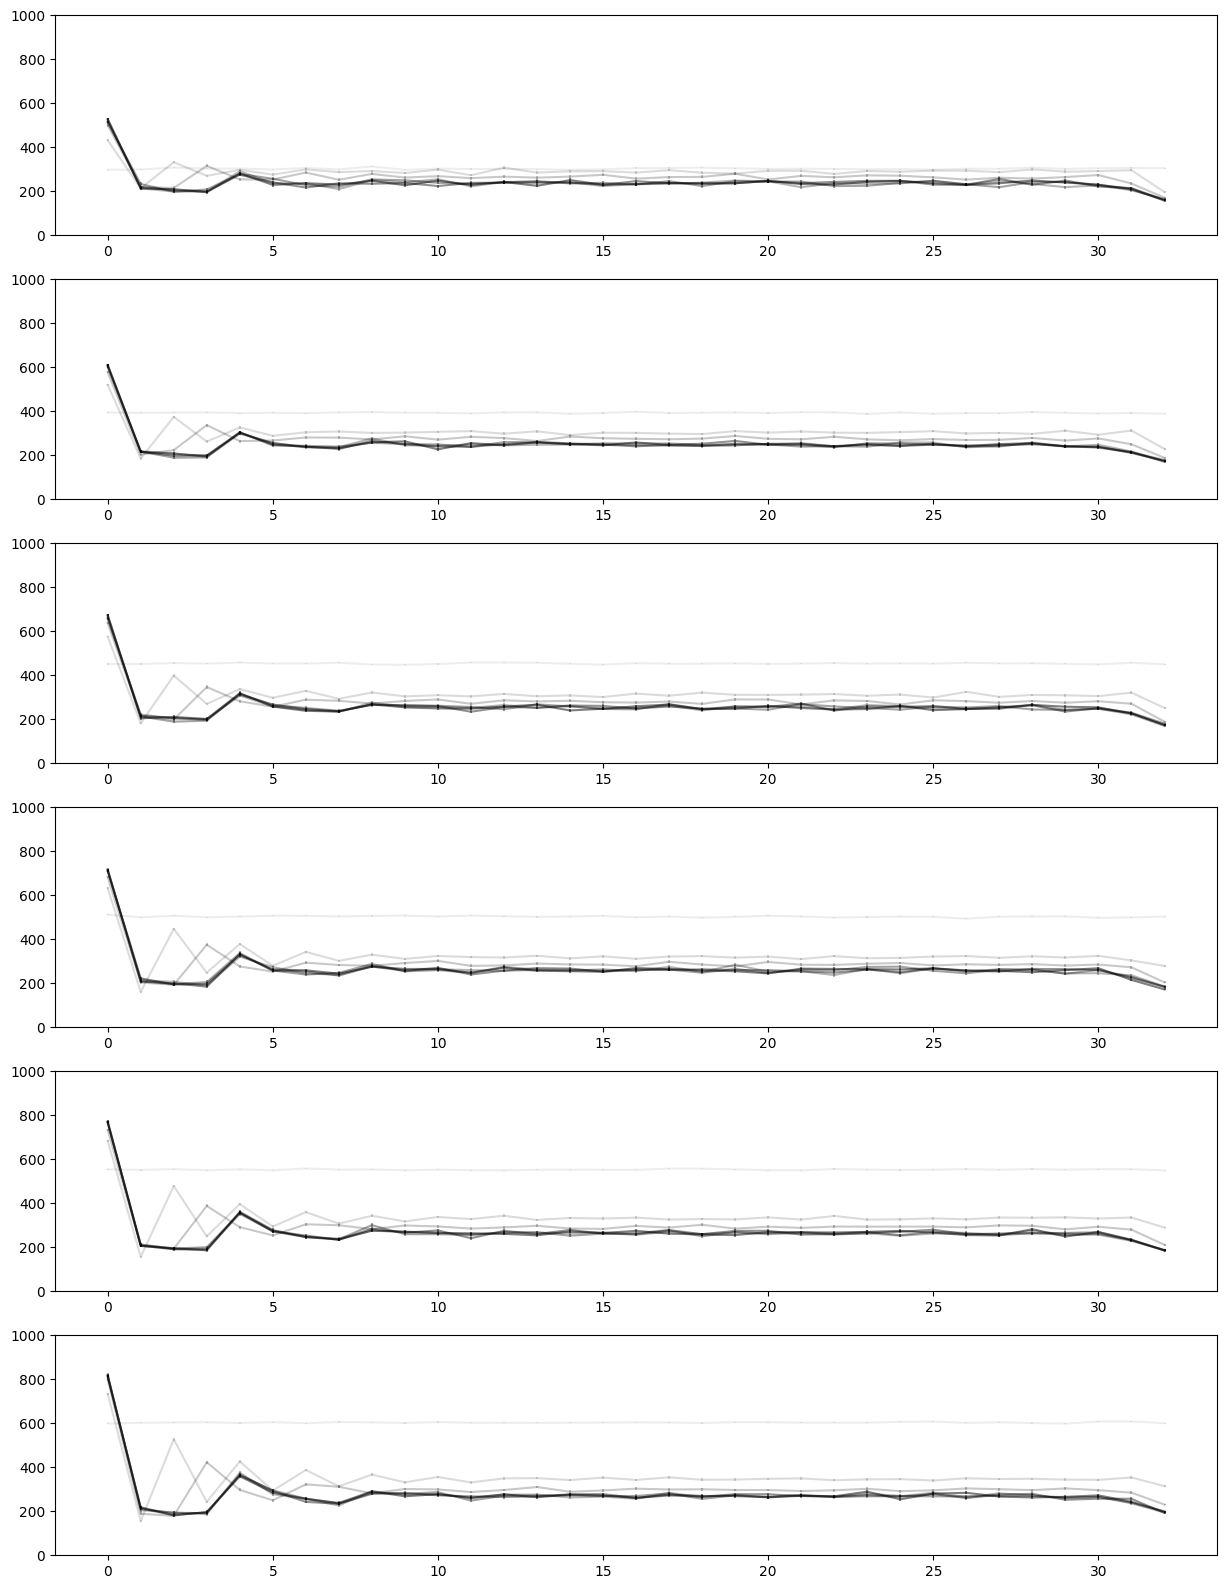

In [48]:
visual_delays = [0, 90, 150, 200, 300, 500 ]
num_sims = 1000
fig, axs = plt.subplots(len(visual_delays), 1, figsize = (15,20))
for ind, visual_delay in enumerate(visual_delays):

    IPI = {window: np.empty((seq_length, num_sims)) for window in [1,2,3,4]}

    for window in tqdm(IPI.keys()):
        model = DriftDiffusionModel_Optimzied(drifts = drifts, diffusion=diffusion, threshold = threshold, window_size=window, visual_delay=visual_delay, planning_capacity=4, planning_param=2, seq_length=seq_length)
        for sim in range(num_sims):
            IPIs = model.simulate()
            IPI[window][:, sim ] = IPIs


    #Calculating mean and std for each window size
    IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
    IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


    for idx, window in enumerate(IPI.keys()):
        axs[ind].errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
        # plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))
        axs[ind].set_ylim([0,1000])

    print("*********Delay = ", visual_delay, " ********************")
    for window in window_sizes:
        print('window = ', window, "   ", np.mean(IPI_mean[window][15:25]))



plt.show()

    # plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
    # plt.xticks(window_sizes)
    # plt.xlabel('Window Size')
    # plt.ylabel('RT')
    # plt.show()


100%|██████████| 7/7 [01:19<00:00, 11.33s/it]


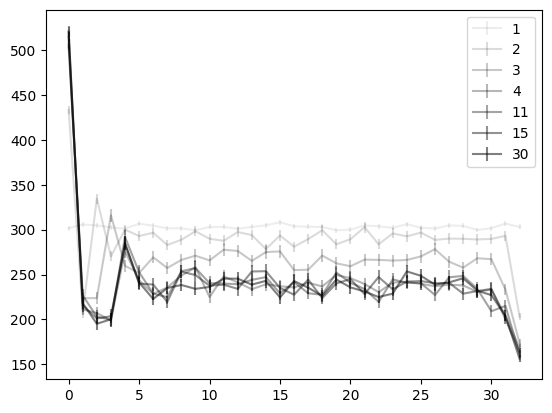

In [38]:

num_sims = 1000
IPI = {window: np.empty((seq_length, num_sims)) for window in window_sizes}

for window in tqdm(IPI.keys()):
    model = DriftDiffusionModel_Optimzied(drifts = drifts, diffusion=diffusion, threshold = threshold, window_size=window, visual_delay=0, planning_capacity=4, planning_param=2, seq_length=seq_length)
    for sim in range(num_sims):
        IPIs = model.simulate()
        IPI[window][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {window: IPI_vals.mean(axis = 1) for window, IPI_vals in IPI.items()}
IPI_std = {window: IPI_vals.std(axis = 1) for window, IPI_vals in IPI.items()}


for idx, window in enumerate(IPI.keys()):
    plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    # plt.errorbar(range(seq_length), IPI_mean[window], label = window, color = 'black', alpha = (idx+1)/(2 *len(window_sizes)))



plt.legend()
plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


In [39]:
for window in window_sizes:
    print('window = ', window, "   ", np.mean(IPI_mean[window][15:25]))


window =  1     303.4239
window =  2     291.1185
window =  3     264.37629999999996
window =  4     239.84959999999995
window =  11     235.88669999999996
window =  15     236.68219999999997
window =  30     234.71259999999998


windw 1 capacity 1 800.0
windw 1 capacity 2 800.0
windw 1 capacity 3 800.0
windw 1 capacity 4 800.0
windw 2 capacity 1 800.0
windw 2 capacity 2 400.1
windw 2 capacity 3 400.1
windw 2 capacity 4 400.1
windw 3 capacity 1 800.0
windw 3 capacity 2 400.1
windw 3 capacity 3 300.4
windw 3 capacity 4 300.4
windw 4 capacity 1 800.0
windw 4 capacity 2 400.1
windw 4 capacity 3 300.4
windw 4 capacity 4 300.2


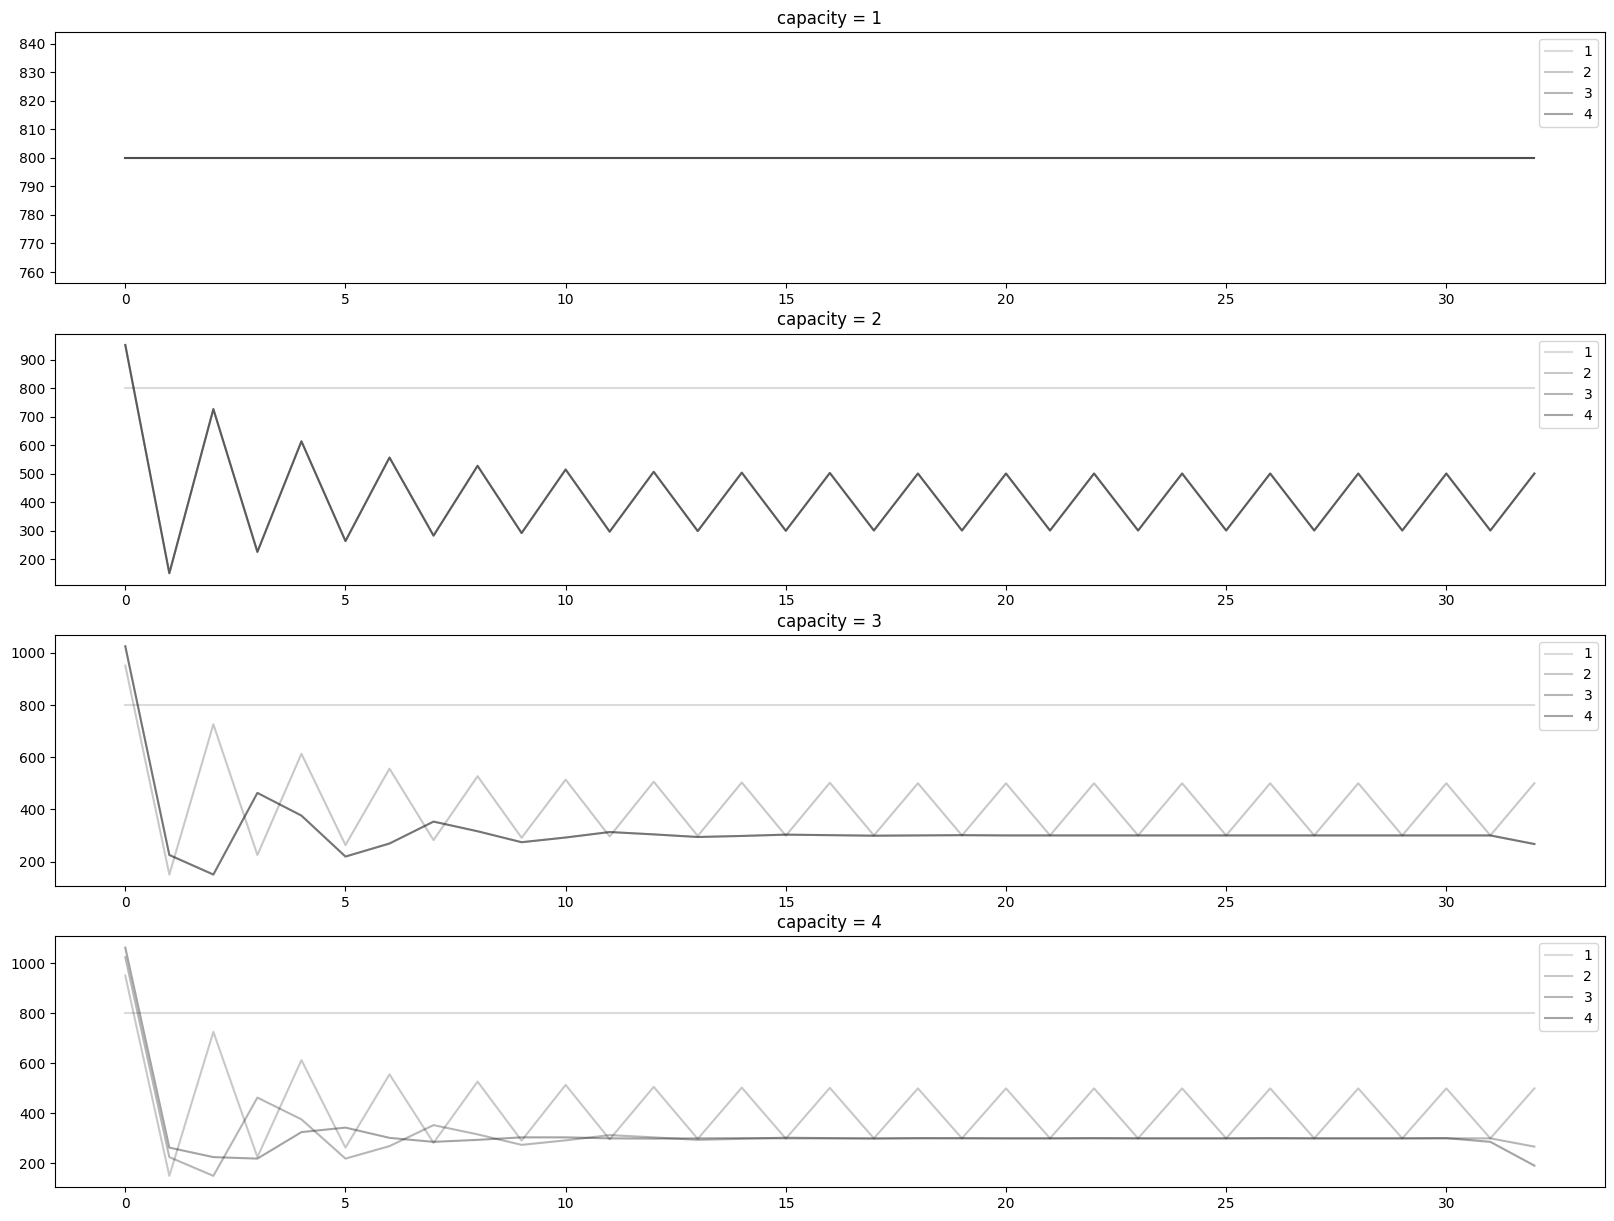

In [50]:
fig, axs = plt.subplots(4, 1, figsize = (20,15))
num_sims = 1
IPI = {(window, capacity): np.empty((seq_length, num_sims)) for (window, capacity) in itertools.product([1, 2, 3, 4], [1, 2, 3, 4])}

for (window, capacity) in IPI.keys():
    model = DriftDiffusionModel_Optimzied(drifts = drifts, diffusion = 0, threshold = threshold, window_size=window, visual_delay=500, planning_capacity=capacity, planning_param=2, seq_length=seq_length)
    for sim in range(num_sims):
        IPIs = model.simulate()
        IPI[(window, capacity)][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {(window, capacity): IPI_vals.mean(axis = 1) for (window, capacity), IPI_vals in IPI.items()}
IPI_std = {(window, capacity): IPI_vals.std(axis = 1) for (window, capacity), IPI_vals in IPI.items()}

for idx, (window, capacity) in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    axs[capacity - 1].errorbar(range(seq_length), IPI_mean[(window, capacity)], label = window, color = 'black', alpha = (window+1)/(2 *len(window_sizes)))
    axs[capacity - 1].legend()
    axs[capacity - 1].set_title(f'capacity = {capacity}')

    print(f'windw {window} capacity {capacity} {np.mean(IPI_mean[(window, capacity)][15:25])}')


plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


windw 1 capacity 1 1200.0
windw 1 capacity 2 1200.0
windw 1 capacity 3 1200.0
windw 1 capacity 4 1200.0
windw 2 capacity 1 1200.0
windw 2 capacity 2 600.1
windw 2 capacity 3 600.1
windw 2 capacity 4 600.1
windw 3 capacity 1 1200.0
windw 3 capacity 2 600.1
windw 3 capacity 3 404.0
windw 3 capacity 4 404.0
windw 4 capacity 1 1200.0
windw 4 capacity 2 600.1
windw 4 capacity 3 404.0
windw 4 capacity 4 304.4


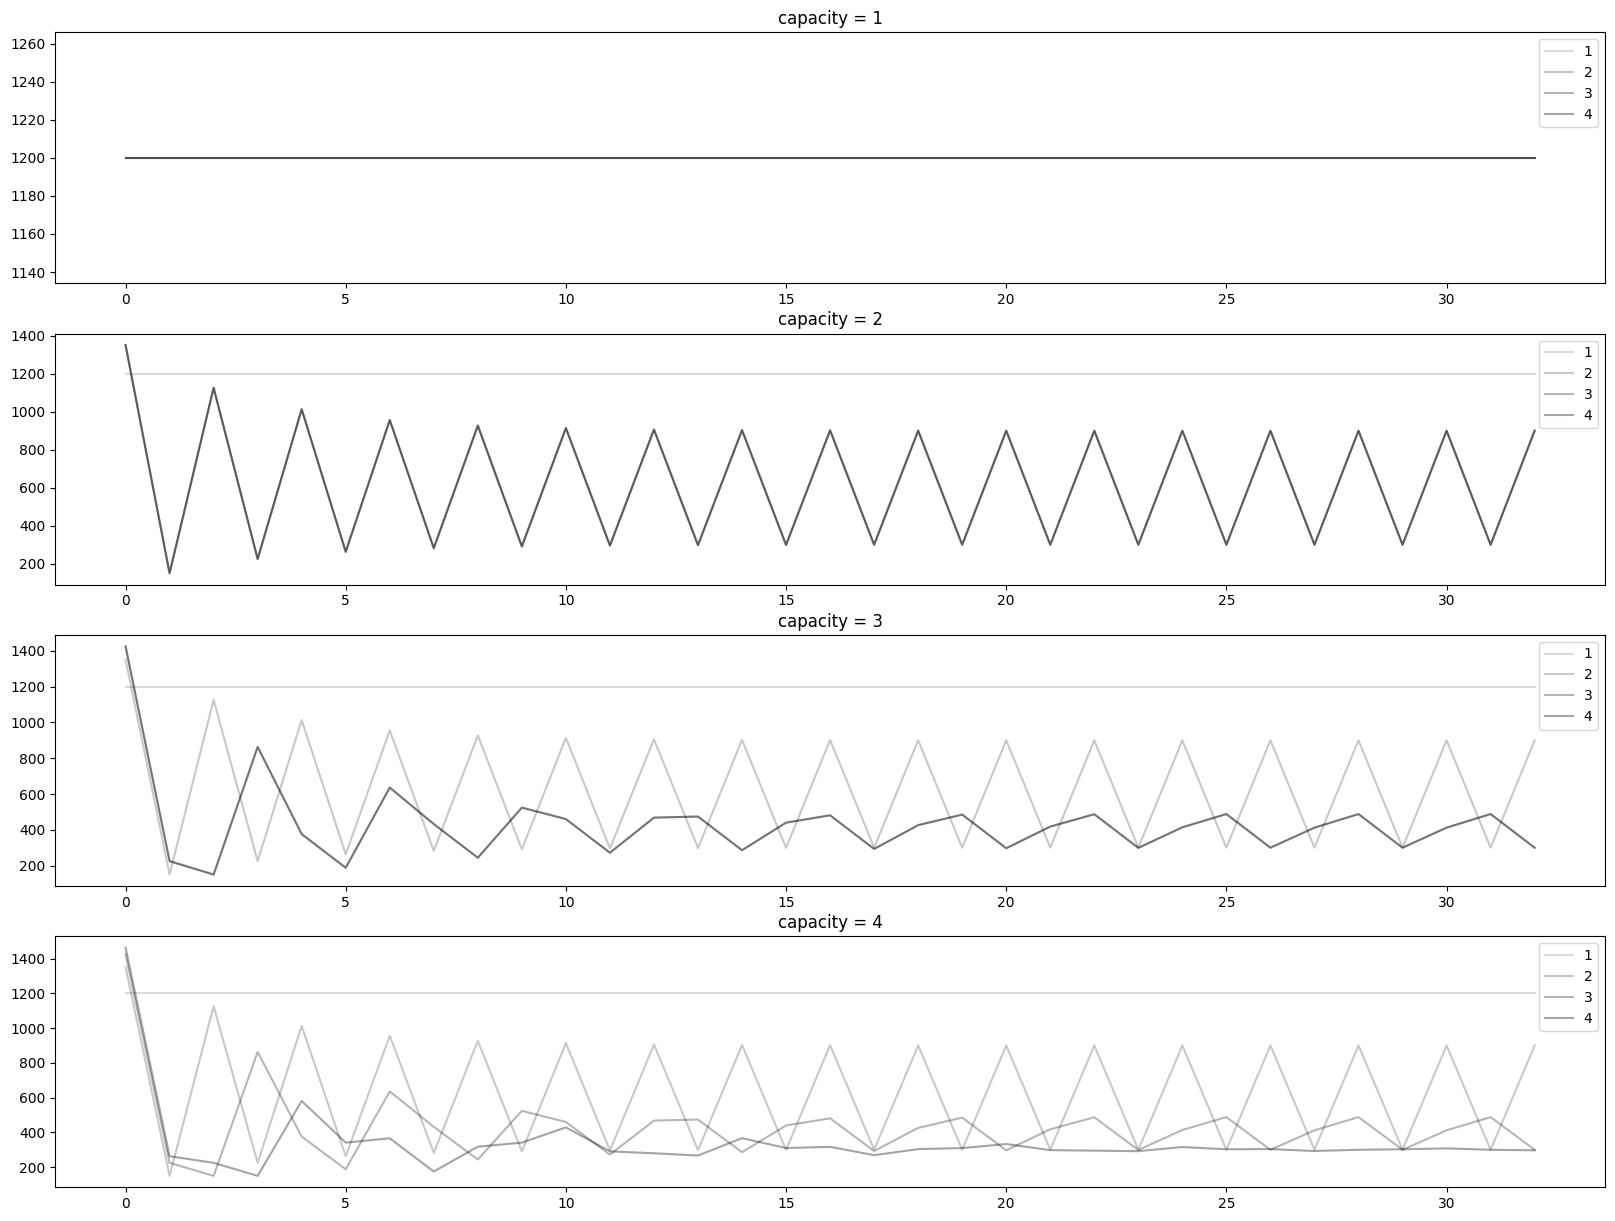

In [51]:
fig, axs = plt.subplots(4, 1, figsize = (20,15))
num_sims = 1
IPI = {(window, capacity): np.empty((seq_length, num_sims)) for (window, capacity) in itertools.product([1, 2, 3, 4], [1, 2, 3, 4])}

for (window, capacity) in IPI.keys():
    model = DriftDiffusionModel_Optimzied(drifts = drifts, diffusion = 0, threshold = threshold, window_size=window, visual_delay=900, planning_capacity=capacity, planning_param=2, seq_length=seq_length)
    for sim in range(num_sims):
        IPIs = model.simulate()
        IPI[(window, capacity)][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {(window, capacity): IPI_vals.mean(axis = 1) for (window, capacity), IPI_vals in IPI.items()}
IPI_std = {(window, capacity): IPI_vals.std(axis = 1) for (window, capacity), IPI_vals in IPI.items()}

for idx, (window, capacity) in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    axs[capacity - 1].errorbar(range(seq_length), IPI_mean[(window, capacity)], label = window, color = 'black', alpha = (window+1)/(2 *len(window_sizes)))
    axs[capacity - 1].legend()
    axs[capacity - 1].set_title(f'capacity = {capacity}')

    print(f'windw {window} capacity {capacity} {np.mean(IPI_mean[(window, capacity)][15:25])}')



plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


windw 1 capacity 1 450.0
windw 1 capacity 2 450.0
windw 1 capacity 3 450.0
windw 1 capacity 4 450.0
windw 2 capacity 1 450.0
windw 2 capacity 2 300.0
windw 2 capacity 3 300.0
windw 2 capacity 4 300.0
windw 3 capacity 1 450.0
windw 3 capacity 2 300.0
windw 3 capacity 3 300.4
windw 3 capacity 4 300.4
windw 4 capacity 1 450.0
windw 4 capacity 2 300.0
windw 4 capacity 3 300.4
windw 4 capacity 4 300.0


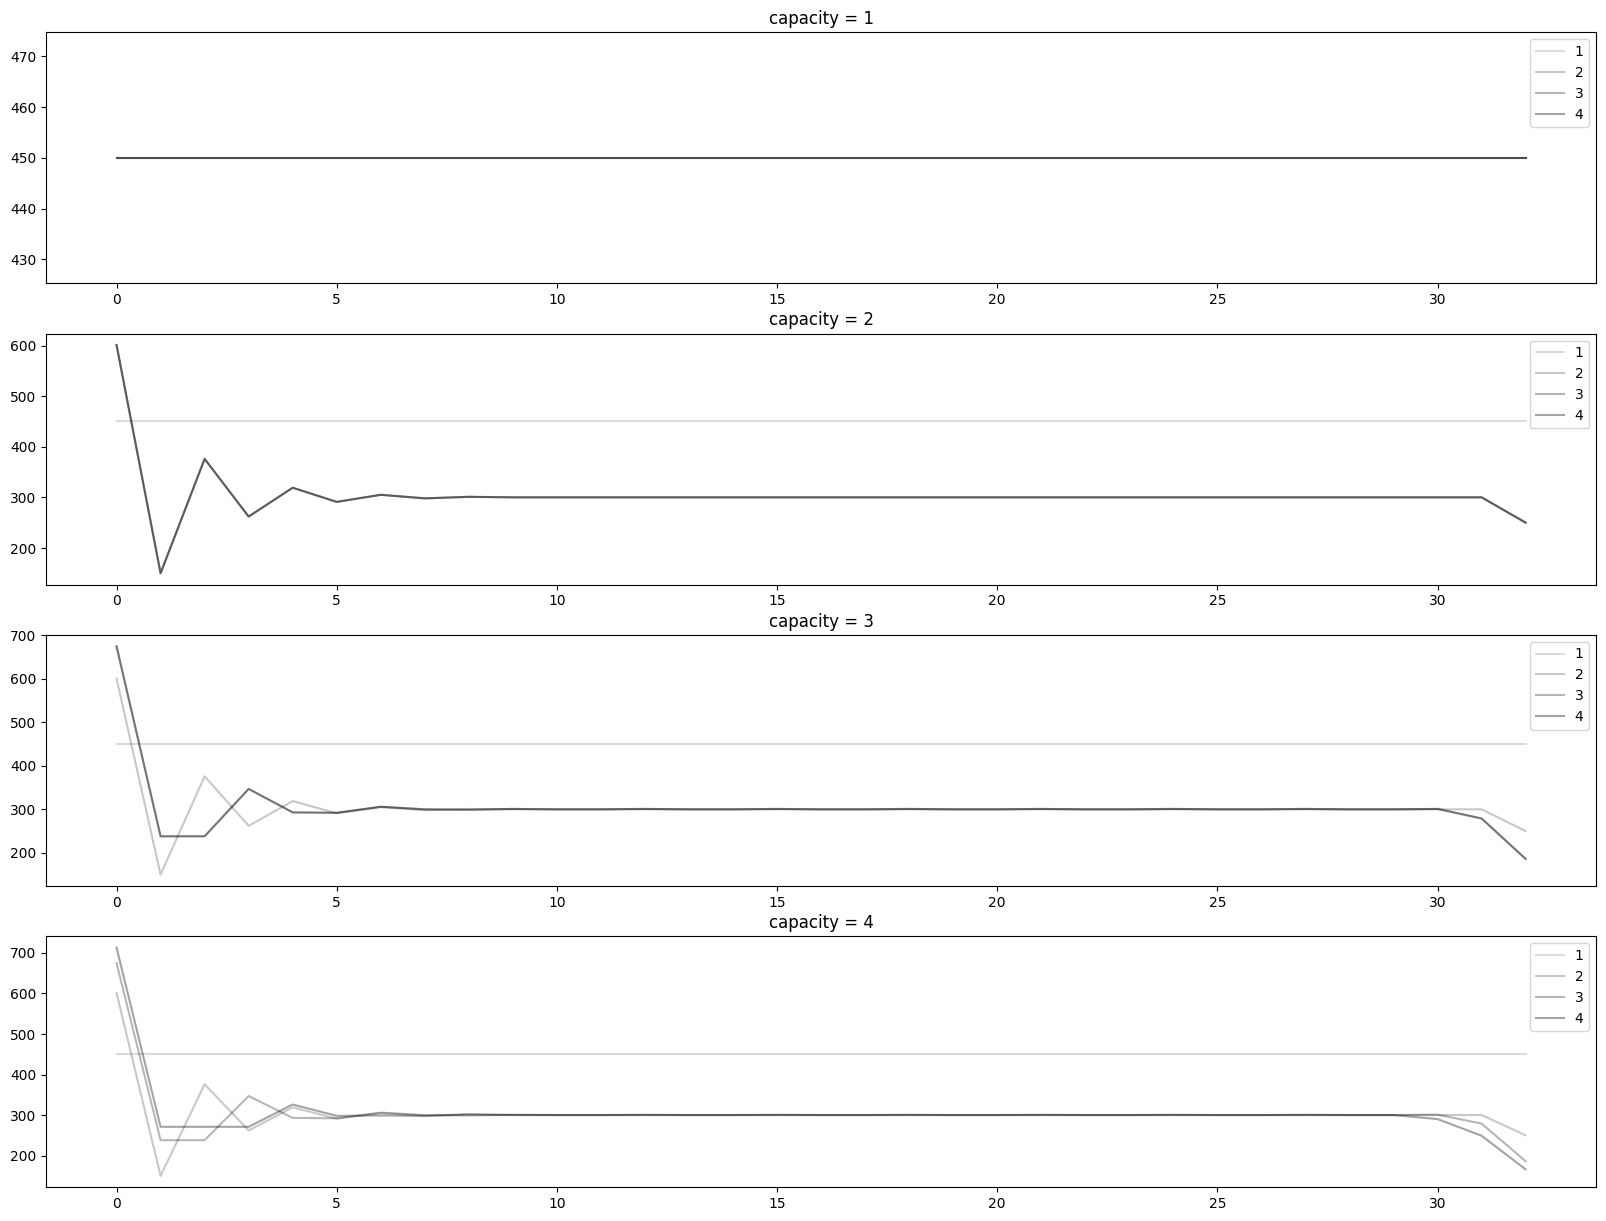

In [52]:
fig, axs = plt.subplots(4, 1, figsize = (20,15))
num_sims = 1
IPI = {(window, capacity): np.empty((seq_length, num_sims)) for (window, capacity) in itertools.product([1, 2, 3, 4], [1, 2, 3, 4])}

for (window, capacity) in IPI.keys():
    model = DriftDiffusionModel_Optimzied(drifts = drifts, diffusion = 0, threshold = threshold, window_size=window, visual_delay=150, planning_capacity=capacity, planning_param=2, seq_length=seq_length)
    for sim in range(num_sims):
        IPIs = model.simulate()
        IPI[(window, capacity)][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {(window, capacity): IPI_vals.mean(axis = 1) for (window, capacity), IPI_vals in IPI.items()}
IPI_std = {(window, capacity): IPI_vals.std(axis = 1) for (window, capacity), IPI_vals in IPI.items()}

for idx, (window, capacity) in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    axs[capacity - 1].errorbar(range(seq_length), IPI_mean[(window, capacity)], label = window, color = 'black', alpha = (window+1)/(2 *len(window_sizes)))
    axs[capacity - 1].legend()
    axs[capacity - 1].set_title(f'capacity = {capacity}')

    print(f'windw {window} capacity {capacity} {np.mean(IPI_mean[(window, capacity)][15:25])}')



plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


windw 1 capacity 1 300.0
windw 1 capacity 2 300.0
windw 1 capacity 3 300.0
windw 1 capacity 4 300.0
windw 2 capacity 1 300.0
windw 2 capacity 2 300.5
windw 2 capacity 3 300.5
windw 2 capacity 4 300.5
windw 3 capacity 1 300.0
windw 3 capacity 2 300.5
windw 3 capacity 3 300.0
windw 3 capacity 4 300.0
windw 4 capacity 1 300.0
windw 4 capacity 2 300.5
windw 4 capacity 3 300.0
windw 4 capacity 4 300.0


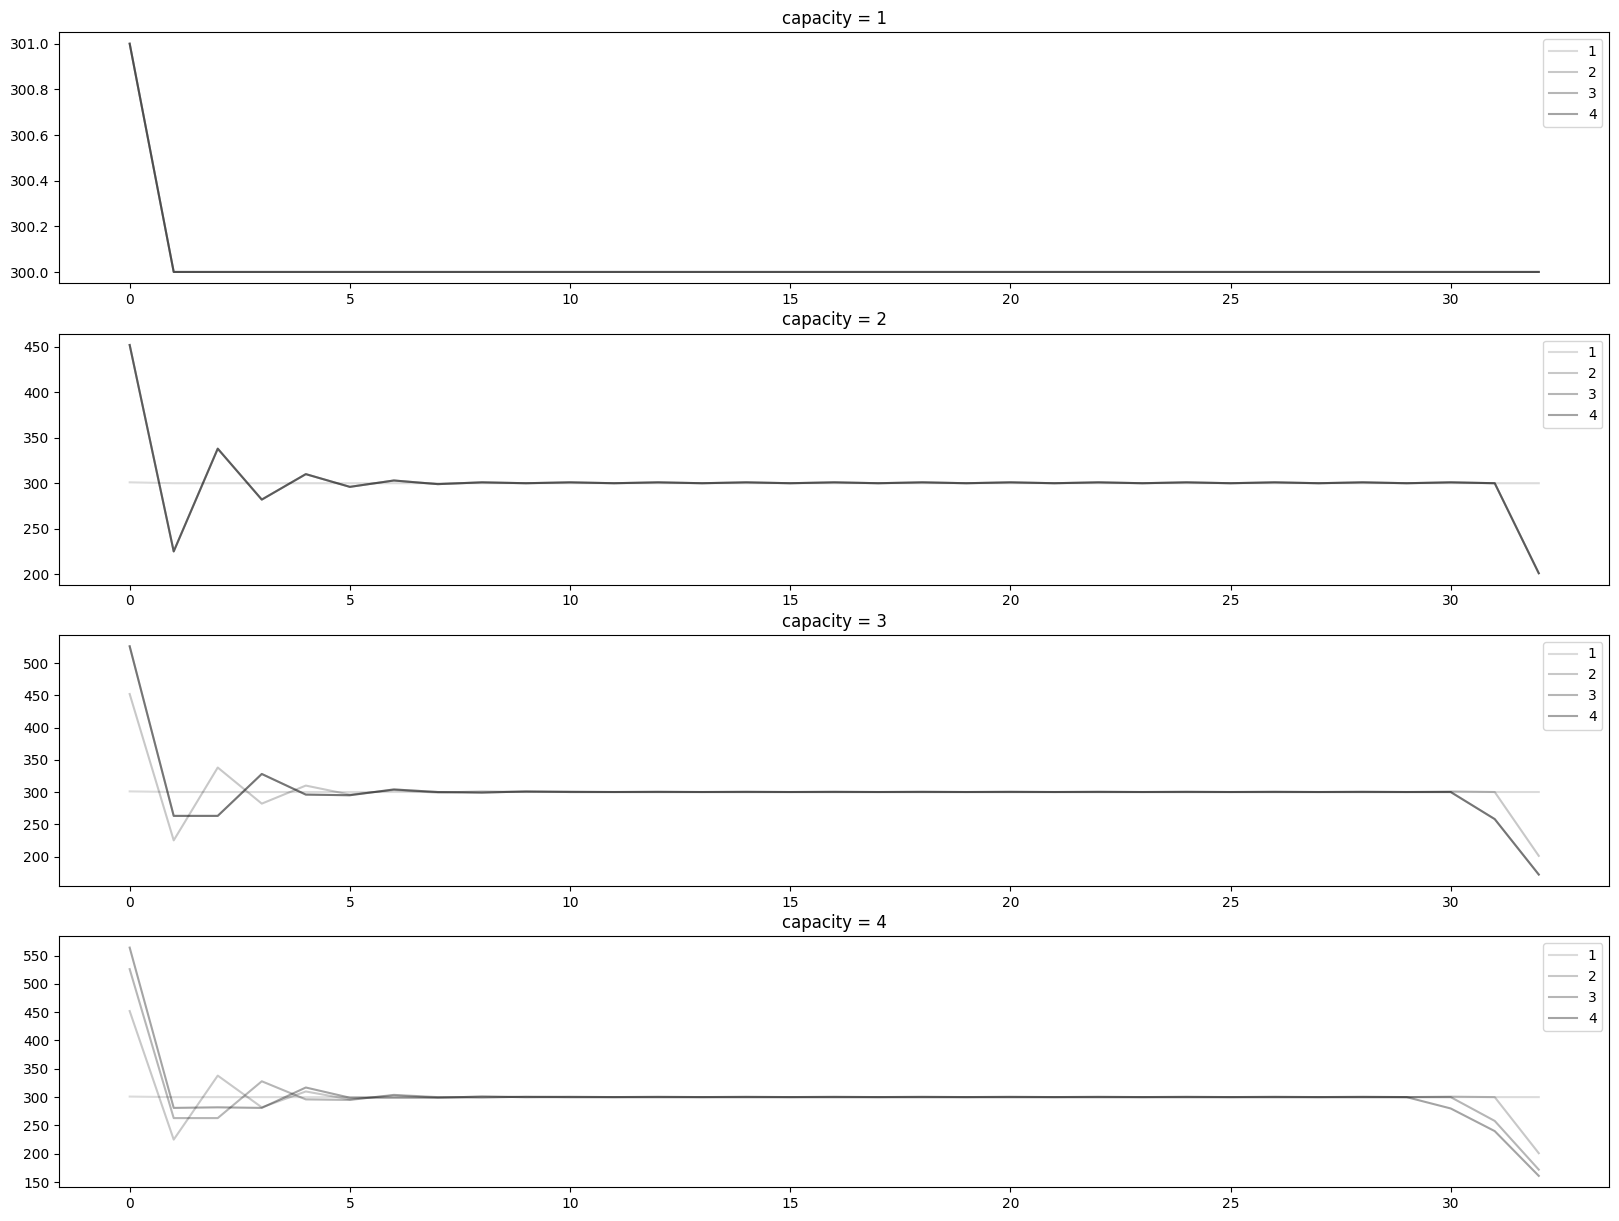

In [53]:
fig, axs = plt.subplots(4, 1, figsize = (20,15))
num_sims = 1
IPI = {(window, capacity): np.empty((seq_length, num_sims)) for (window, capacity) in itertools.product([1, 2, 3, 4], [1, 2, 3, 4])}

for (window, capacity) in IPI.keys():
    model = DriftDiffusionModel_Optimzied(drifts = drifts, diffusion = 0, threshold = threshold, window_size=window, visual_delay=0, planning_capacity=capacity, planning_param=2, seq_length=seq_length)
    for sim in range(num_sims):
        IPIs = model.simulate()
        IPI[(window, capacity)][:, sim ] = IPIs


#Calculating mean and std for each window size
IPI_mean = {(window, capacity): IPI_vals.mean(axis = 1) for (window, capacity), IPI_vals in IPI.items()}
IPI_std = {(window, capacity): IPI_vals.std(axis = 1) for (window, capacity), IPI_vals in IPI.items()}

for idx, (window, capacity) in enumerate(IPI.keys()):
    # plt.errorbar(range(seq_length), IPI_mean[window], yerr = IPI_std[window]/np.sqrt(num_sims), label = window, color = 'black',  alpha = (idx+1)/(2 *len(window_sizes)))
    axs[capacity - 1].errorbar(range(seq_length), IPI_mean[(window, capacity)], label = window, color = 'black', alpha = (window+1)/(2 *len(window_sizes)))
    axs[capacity - 1].legend()
    axs[capacity - 1].set_title(f'capacity = {capacity}')

    print(f'windw {window} capacity {capacity} {np.mean(IPI_mean[(window, capacity)][15:25])}')



plt.show()

# plt.errorbar(RT_mean.keys(), RT_mean.values(), yerr=list(RT_std.values()), fmt='-o')
# plt.xticks(window_sizes)
# plt.xlabel('Window Size')
# plt.ylabel('RT')
# plt.show()


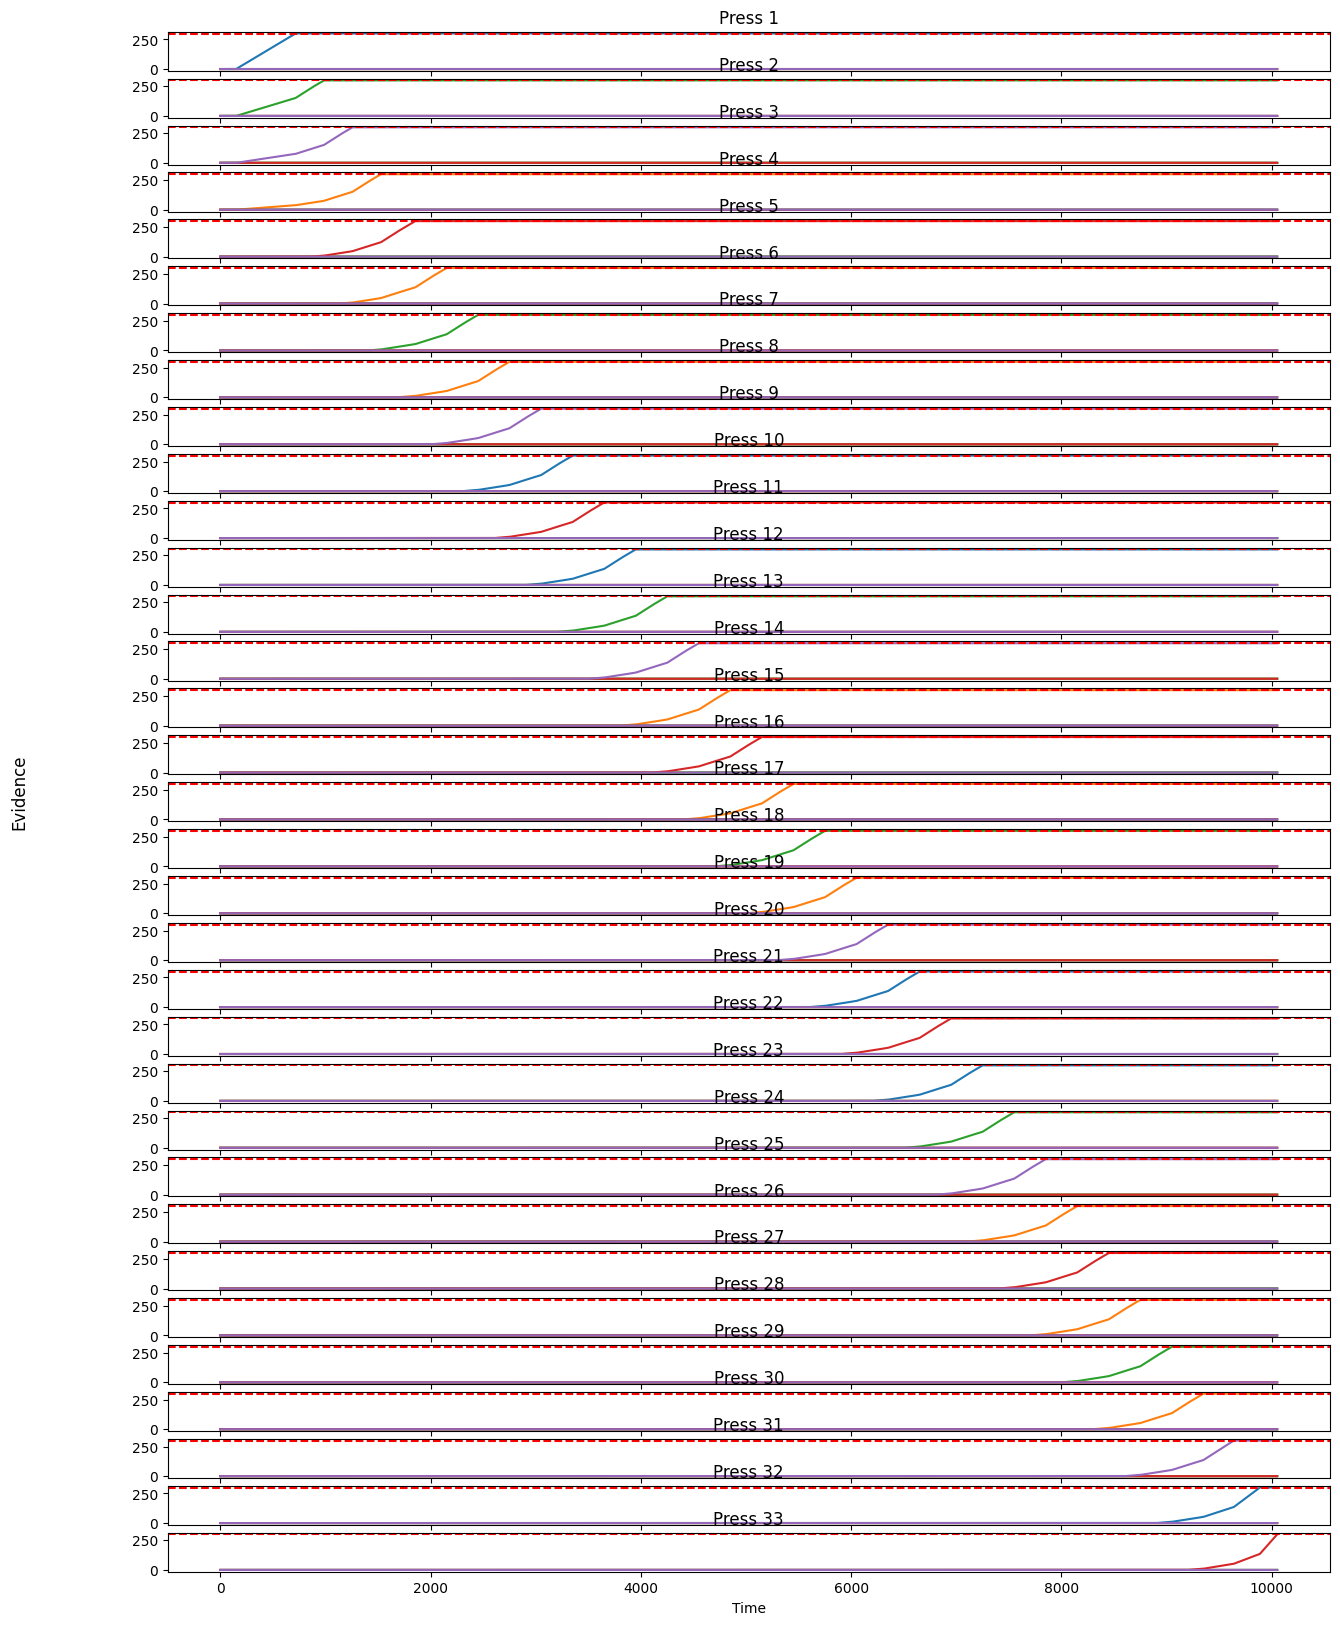

In [10]:
model = DriftDiffusionModel(drifts = drifts, diffusion = 0, threshold = threshold, window_size=11, visual_delay=150, planning_capacity=4, planning_param=2)
model.plot_simulations()
# model.simulate()
# model.plot_IPIs()

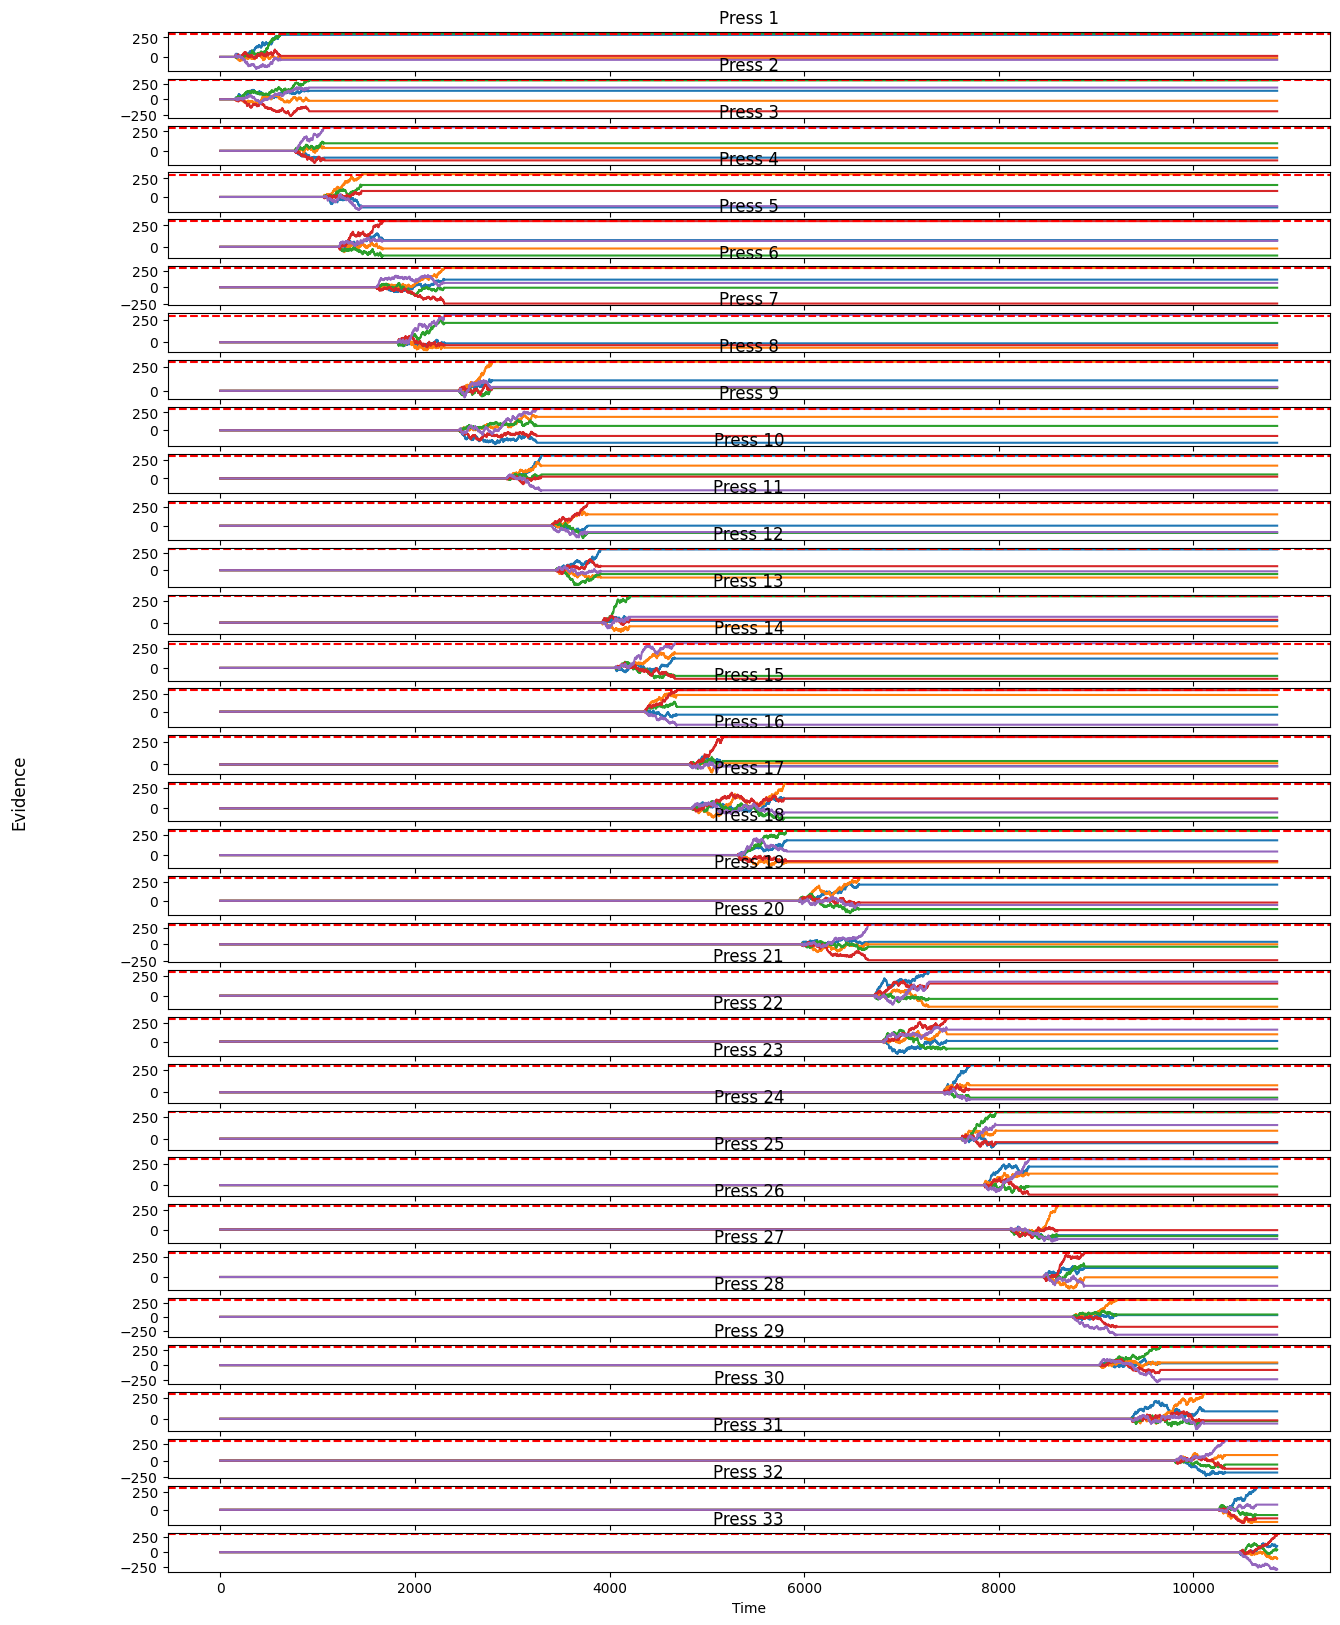

In [10]:
model = DriftDiffusionModel(drifts, diffusion, threshold, window_size=2, visual_delay=150, planning_capacity=4, planning_param=2)
model.plot_simulations()
# model.simulate()
# model.plot_IPIs()

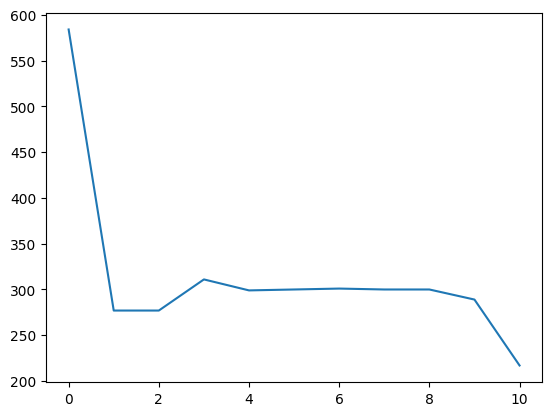

In [ ]:

model = DriftDiffusionModel(drifts, diffusion = 0, threshold = threshold, visual_delay=150, window_size=3, planning_capacity=4, planning_param=3)
# model.plot_simulations()
model.simulate()
model.plot_IPIs()